In [167]:
# get gps data and do interpolate

import pandas as pd
import numpy as np

# Select start and end date
start_date = '2023-07-14 10:22:00'
end_date = '2023-07-14 10:44:00'

# Load the CSV data_gps into a data_gpsFrame
data_gps = pd.read_csv('data_0714/pixhawk_gps_1689322326086276514.csv', skipinitialspace=True)

# Convert received_time to datetime format
data_gps['received_time'] = pd.to_datetime(data_gps['received_time'], unit='ns')

# Localize the timestamp to GMT first (assuming the original time is in GMT)
data_gps['received_time'] = data_gps['received_time'].dt.tz_localize('GMT')

# Convert to Rome time
data_gps['received_time'] = data_gps['received_time'].dt.tz_convert('Europe/Rome')

# Filter data based on the date range
mask = (data_gps['received_time'] > start_date) & (data_gps['received_time'] <= end_date)
data_gps = data_gps.loc[mask]

print(data_gps.head())

# Sort the DataFrame by received_time
data_gps = data_gps.sort_values('received_time')

# Replace empty strings with NaN
data_gps.replace('', np.nan, inplace=True)

# Set received_time as the index (required for interpolation)
data_gps.set_index('received_time', inplace=True)

# Interpolate the missing values based on the index (received_time)
data_gps_interpolated = data_gps.astype('float').interpolate(method='time')

# Reset the index
data_gps_interpolated.reset_index(inplace=True)

data_gps_interpolated = data_gps_interpolated.drop(data_gps_interpolated.index[0])

# Divide by a large number to get latitude and longitude values in the correct range
data_gps_interpolated['lat'] = data_gps_interpolated['lat'] / 1e7
data_gps_interpolated['lon'] = data_gps_interpolated['lon'] / 1e7

# Print the resulting DataFrame

data_gps_interpolated
data_gps.reset_index(inplace=True)


                          received_time  altitude          lat          lon  \
538 2023-07-14 10:22:02.701129674+02:00  1.906207          NaN          NaN   
539 2023-07-14 10:22:02.737173874+02:00       NaN  460684909.0  112273196.0   
540 2023-07-14 10:22:05.531304480+02:00       NaN  460684907.0  112273171.0   
541 2023-07-14 10:22:05.544178268+02:00  2.077919          NaN          NaN   
542 2023-07-14 10:22:08.364011346+02:00       NaN  460684917.0  112273177.0   

          alt  
538       NaN  
539  471548.0  
540  472711.0  
541       NaN  
542  473735.0  


In [168]:
# get lora data

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
data_lora = pd.read_csv('data_0714/lora_module_received_1689321731873899299.csv', skipinitialspace=True)

# Filter the DataFrame
data_lora = data_lora[data_lora['packet_text'].isin(['2', '3', '4', '5'])]

# Convert the received_time to datetime format
data_lora['received_time'] = pd.to_datetime(data_lora['received_time'], unit='ns')

# Localize the timestamp to GMT first (assuming the original time is in GMT)
data_lora['received_time'] = data_lora['received_time'].dt.tz_localize('GMT')

# Convert to Rome time
data_lora['received_time'] = data_lora['received_time'].dt.tz_convert('Europe/Rome')

# Filter data based on the date range
mask = (data_lora['received_time'] > start_date) & (data_lora['received_time'] <= end_date)
data_lora = data_lora.loc[mask]

data_lora

,received_time,packet_text,rssi
4205,2023-07-14 10:22:00.067502080+02:00,2,-100.0
4206,2023-07-14 10:22:00.216883200+02:00,5,-99.0
4207,2023-07-14 10:22:00.336206848+02:00,3,-96.0
4208,2023-07-14 10:22:00.446881792+02:00,4,-99.0
4209,2023-07-14 10:22:00.665605632+02:00,4,-100.0
...,...,...,...
13033,2023-07-14 10:43:59.603115264+02:00,3,-95.0
13034,2023-07-14 10:43:59.744740096+02:00,2,-106.0
13035,2023-07-14 10:43:59.807896320+02:00,4,-98.0
13036,2023-07-14 10:43:59.882705408+02:00,2,-106.0


In [169]:
# merge gps and lora data

# Load the dataframes
df1 = data_gps_interpolated

df2 = data_lora
df2["altitude"] = np.nan
df2["lat"] = np.nan
df2["lon"] = np.nan
df2["alt"] = np.nan

# Define a function to find the index of the closest timestamp in df2
def find_closest(row):
    diff = np.abs(df2['received_time'] - row['received_time'])
    idx = diff.idxmin()
    return idx

# Apply the function to each row in df1
df1['closest_idx'] = df1.apply(find_closest, axis=1)

for index, row in df1.iterrows():
    df2["altitude"][row["closest_idx"]] = row["altitude"]
    df2["lat"][row["closest_idx"]] = row["lat"]
    df2["lon"][row["closest_idx"]] = row["lon"]
    df2["alt"][row["closest_idx"]] = row["alt"]

# Set received_time as the index (required for interpolation)
df2.set_index('received_time', inplace=True)

# Interpolate the missing values based on the index (received_time)
df2_interpolated = df2.astype('float').interpolate(method='time')

# Reset the index
df2_interpolated.reset_index(inplace=True)

df2_interpolated = df2_interpolated.drop(df2_interpolated.index[:df2_interpolated.isna().any(axis=1).sum()])

print(df2_interpolated.isna().any(axis=1).sum())

df2_interpolated

/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_37322/3860784915.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["altitude"][row["closest_idx"]] = row["altitude"]
/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_37322/3860784915.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["lat"][row["closest_idx"]] = row["lat"]
/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_37322/3860784915.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

0


,received_time,packet_text,rssi,altitude,lat,lon,alt
17,2023-07-14 10:22:02.767520+02:00,4.0,-98.0,1.908384,46.068491,11.227320,471548.000000
18,2023-07-14 10:22:03.061225472+02:00,5.0,-99.0,1.926274,46.068491,11.227319,471671.211482
19,2023-07-14 10:22:03.205131776+02:00,3.0,-97.0,1.935039,46.068491,11.227319,471731.581174
20,2023-07-14 10:22:03.399057408+02:00,5.0,-99.0,1.946851,46.068491,11.227319,471812.934321
21,2023-07-14 10:22:03.471058688+02:00,4.0,-100.0,1.951236,46.068491,11.227319,471843.139358
...,...,...,...,...,...,...,...
8747,2023-07-14 10:43:59.603115264+02:00,3.0,-95.0,-0.922938,46.068470,11.227280,469739.000000
8748,2023-07-14 10:43:59.744740096+02:00,2.0,-106.0,-0.922938,46.068470,11.227280,469739.000000
8749,2023-07-14 10:43:59.807896320+02:00,4.0,-98.0,-0.922938,46.068470,11.227280,469739.000000
8750,2023-07-14 10:43:59.882705408+02:00,2.0,-106.0,-0.922938,46.068470,11.227280,469739.000000


In [170]:
# calculate distance and add column

import pandas as pd
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import pyproj
import folium

# Load the dataframes
beacon_locations = pd.read_csv('data_0714/beacon_location_large.csv', skipinitialspace=True)

# Create a map centered around the average latitude and longitude
m = folium.Map(location=[beacon_locations['lat'].mean(), beacon_locations['lon'].mean()], zoom_start=15)

# Add a marker for each beacon
for _, row in beacon_locations.iterrows():
    folium.Marker([row['lat'], row['lon']], popup='Beacon {}'.format(row['beacon_id'])).add_to(m)

# Display the map
m


# Define a function to calculate the distance between two points
def to_cartesian(lat, lon, alt):
    x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
    return x, y, z

def calculate_distance(lat1, lon1, alt1, lat2, lon2, alt2):
    x1, y1, z1 = to_cartesian(lat1, lon1, alt1)
    x2, y2, z2 = to_cartesian(lat2, lon2, alt2)
    distance = sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

    return distance

df2_interpolated["dist"] = np.nan

for index, row in df2_interpolated.iterrows():
    beacon_info = beacon_locations.loc[beacon_locations["beacon_id"]==int(row["packet_text"])]
    beacon_locations.loc[beacon_locations["beacon_id"]==4]

    df2_interpolated["dist"][index] = calculate_distance(beacon_info["lat"].values[0], beacon_info["lon"].values[0], 0, row["lat"], row["lon"], row["altitude"])
# Print the resulting dataframe
print(df2_interpolated)


/var/folders/4x/r862jfdj31g0f_d96v7w91f80000gp/T/ipykernel_37322/2764481437.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_interpolated["dist"][index] = calculate_distance(beacon_info["lat"].values[0], beacon_info["lon"].values[0], 0, row["lat"], row["lon"], row["altitude"])


                           received_time  packet_text   rssi  altitude  \
17      2023-07-14 10:22:02.767520+02:00          4.0  -98.0  1.908384   
18   2023-07-14 10:22:03.061225472+02:00          5.0  -99.0  1.926274   
19   2023-07-14 10:22:03.205131776+02:00          3.0  -97.0  1.935039   
20   2023-07-14 10:22:03.399057408+02:00          5.0  -99.0  1.946851   
21   2023-07-14 10:22:03.471058688+02:00          4.0 -100.0  1.951236   
...                                  ...          ...    ...       ...   
8747 2023-07-14 10:43:59.603115264+02:00          3.0  -95.0 -0.922938   
8748 2023-07-14 10:43:59.744740096+02:00          2.0 -106.0 -0.922938   
8749 2023-07-14 10:43:59.807896320+02:00          4.0  -98.0 -0.922938   
8750 2023-07-14 10:43:59.882705408+02:00          2.0 -106.0 -0.922938   
8751 2023-07-14 10:43:59.926776576+02:00          3.0  -96.0 -0.922938   

            lat        lon            alt       dist  
17    46.068491  11.227320  471548.000000  22.772017  
1

In [186]:
import folium
# Load the dataframes
beacon_locations = pd.read_csv('data_0714/beacon_location_large.csv', skipinitialspace=True)

# Create a map centered around the average latitude and longitude
m = folium.Map(location=[beacon_locations['lat'].mean(), beacon_locations['lon'].mean()], zoom_start=19)

# Add a marker for each beacon
for _, row in beacon_locations.iterrows():
    folium.Marker([row['lat'], row['lon']], popup='Beacon {}'.format(row['beacon_id'])).add_to(m)

# Display the map
m

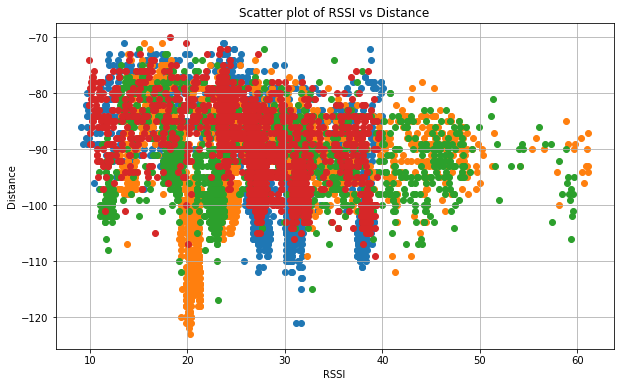

In [174]:
# visualize data for each beacon

import matplotlib.pyplot as plt

# Create a scatter plot with a logarithmic scale for the distances
plt.figure(figsize=(10, 6))
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['rssi'])
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['rssi'])
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['rssi'])
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['rssi'])
plt.xlabel('RSSI')
plt.ylabel('Distance')
plt.title('Scatter plot of RSSI vs Distance')
plt.grid(True)
plt.show()


n = 1.056243078469322
C = -78.66016613612275


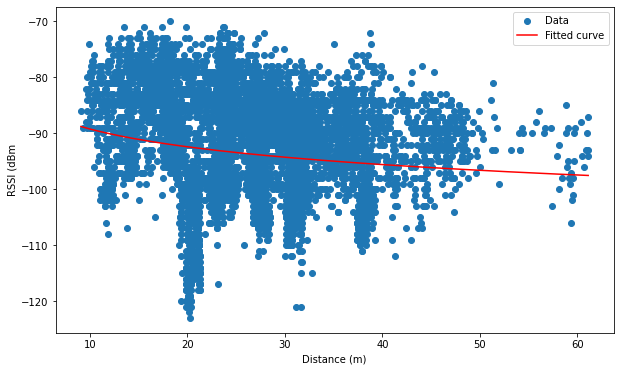

In [190]:
# curve fit with all beacons

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated['dist'], df2_interpolated['rssi'])

# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df2_interpolated['dist'], df2_interpolated['rssi'], label='Data')
distances = np.linspace(df2_interpolated['dist'].min(), df2_interpolated['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), 'r', label='Fitted curve')
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm')
plt.legend()
plt.show()


n = 4.651357391247673
C = -27.273833007687845
n = -1.1987688360478752
C = -111.32826940153666
n = -0.12698556878487244
C = -94.47609581357924
n = 3.138521903994284
C = -47.33282428745067


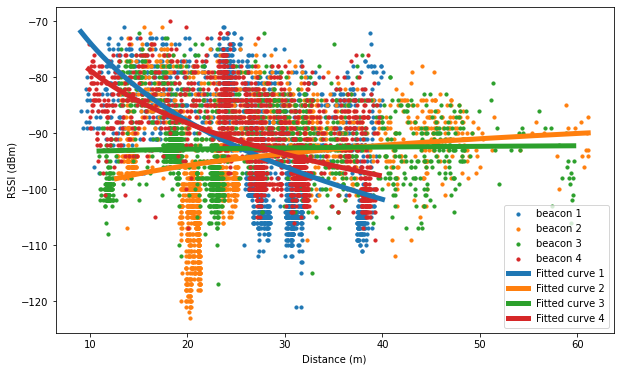

In [191]:
# curve fit with each beacon

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['rssi'])
popt2, pcov2 = curve_fit(func, df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['rssi'])
popt3, pcov3 = curve_fit(func, df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['rssi'])
popt4, pcov4 = curve_fit(func, df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['rssi'])


# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])
# Print the optimal parameters
print('n =', popt2[0])
print('C =', popt2[1])
# Print the optimal parameters
print('n =', popt3[0])
print('C =', popt3[1])
# Print the optimal parameters
print('n =', popt4[0])
print('C =', popt4[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['rssi'], label='beacon 1', s=10) # beacon 2
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['rssi'], label='beacon 2', s=10) # beacon 3
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['rssi'], label='beacon 3', s=10) # beacon 4
plt.scatter(df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'], df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['rssi'], label='beacon 4', s=10) # beacon 5
distances = np.linspace(df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'].min(), df2_interpolated.loc[df2_interpolated["packet_text"]==2.0]['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), label='Fitted curve 1', linewidth=5) # beacon 2
distances2 = np.linspace(df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'].min(), df2_interpolated.loc[df2_interpolated["packet_text"]==3.0]['dist'].max(), 1000)
plt.plot(distances2, func(distances2, *popt2), label='Fitted curve 2', linewidth=5) # beacon 3
distances3 = np.linspace(df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'].min(), df2_interpolated.loc[df2_interpolated["packet_text"]==4.0]['dist'].max(), 1000)
plt.plot(distances3, func(distances3, *popt3), label='Fitted curve 3', linewidth=5) # beacon 4
distances4 = np.linspace(df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'].min(), df2_interpolated.loc[df2_interpolated["packet_text"]==5.0]['dist'].max(), 1000)
plt.plot(distances4, func(distances4, *popt4), label='Fitted curve 4', linewidth=5) # beacon 5
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm)')
plt.legend()
plt.show()

In [ ]:
# curve fit with each experiment
# might have been covering the beacon while the drone was on the ground

In [192]:
# Select different time spans
start_date1 = '2023-07-14 10:23:30+02:00'
end_date1 = '2023-07-14 10:26:00+02:00'

start_date2 = '2023-07-14 10:30:00+02:00'
end_date2 = '2023-07-14 10:33:00+02:00'

start_date3 = '2023-07-14 10:39:30+02:00'
end_date3 = '2023-07-14 10:43:00+02:00'

# Filter data based on the date ranges
mask1 = (df2_interpolated['received_time'] >= start_date1) & (df2_interpolated['received_time'] <= end_date1)
mask2 = (df2_interpolated['received_time'] >= start_date2) & (df2_interpolated['received_time'] <= end_date2)
mask3 = (df2_interpolated['received_time'] >= start_date3) & (df2_interpolated['received_time'] <= end_date3)

# Create a combined mask
mask = mask1 | mask2 | mask3

# Apply the mask
df2_interpolated_masked = df2_interpolated.loc[mask]

n = 1.71965037715049
C = -62.44500667673965


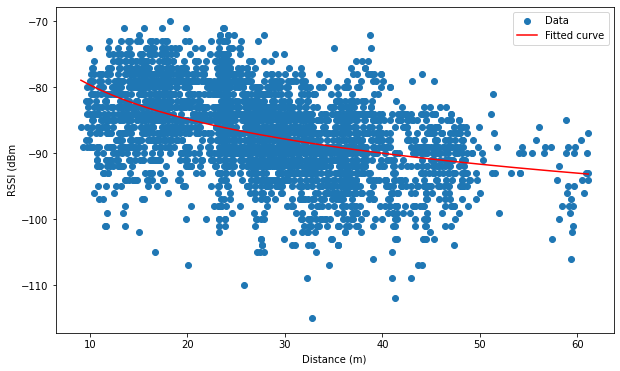

In [196]:
# curve fit with all beacons

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated_masked['dist'], df2_interpolated_masked['rssi'])

# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6), facecolor="white")
plt.scatter(df2_interpolated_masked['dist'], df2_interpolated_masked['rssi'], label='Data')
distances = np.linspace(df2_interpolated_masked['dist'].min(), df2_interpolated_masked['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), 'r', label='Fitted curve')
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm')
plt.legend()
plt.show()


n = 1.1596724942534944
C = -68.6172279969841
n = 2.0083662862673526
C = -58.084165404789154
n = 2.3602625515962536
C = -54.402767594605436
n = 0.8885158317776025
C = -74.11300195510046


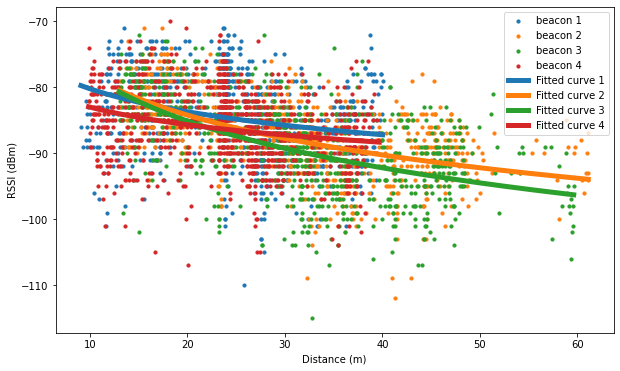

In [197]:
# curve fit with each beacon

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the function to fit
def func(d, n, C):
    return -10 * n * np.log10(d) + C

# Fit the function to the data
popt, pcov = curve_fit(func, df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['rssi'])
popt2, pcov2 = curve_fit(func, df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['rssi'])
popt3, pcov3 = curve_fit(func, df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['rssi'])
popt4, pcov4 = curve_fit(func, df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['rssi'])


# Print the optimal parameters
print('n =', popt[0])
print('C =', popt[1])
# Print the optimal parameters
print('n =', popt2[0])
print('C =', popt2[1])
# Print the optimal parameters
print('n =', popt3[0])
print('C =', popt3[1])
# Print the optimal parameters
print('n =', popt4[0])
print('C =', popt4[1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6), facecolor="white")
plt.scatter(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['rssi'], label='beacon 1', s=10) # beacon 2
plt.scatter(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['rssi'], label='beacon 2', s=10) # beacon 3
plt.scatter(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['rssi'], label='beacon 3', s=10) # beacon 4
plt.scatter(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['dist'], df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['rssi'], label='beacon 4', s=10) # beacon 5
distances = np.linspace(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['dist'].min(), df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==2.0]['dist'].max(), 1000)
plt.plot(distances, func(distances, *popt), label='Fitted curve 1', linewidth=5) # beacon 2
distances2 = np.linspace(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['dist'].min(), df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]['dist'].max(), 1000)
plt.plot(distances2, func(distances2, *popt2), label='Fitted curve 2', linewidth=5) # beacon 3
distances3 = np.linspace(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['dist'].min(), df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==4.0]['dist'].max(), 1000)
plt.plot(distances3, func(distances3, *popt3), label='Fitted curve 3', linewidth=5) # beacon 4
distances4 = np.linspace(df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['dist'].min(), df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==5.0]['dist'].max(), 1000)
plt.plot(distances4, func(distances4, *popt4), label='Fitted curve 4', linewidth=5) # beacon 5
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm)')
plt.legend()
plt.show()

In [243]:
# 2,46.068725,11.227252 
# 3,46.068270,11.227324
# 4,46.068314,11.227466
# 5,46.068686,11.227102

import pandas as pd
import plotly.graph_objects as go

# Create a dataframe
df = df2_interpolated_masked.loc[df2_interpolated_masked["packet_text"]==3.0]


# Define the color scale
color_scale = [[0, 'green'], [0.5, 'yellow'], [1.0, 'red']]

# Create the Scattergeo graph object
fig = go.Figure(data=go.Scattermapbox(
    lon = df['lon'],
    lat = df['lat'],
    text = df['rssi'],
    mode = 'markers',
    marker = dict(
        size = 10,
        color = df['rssi'],
        colorscale = color_scale,
        reversescale = True,
        opacity = 0.7,
        colorbar = dict(title = "RSSI")
    )
    
))

fig.add_trace(go.Scattermapbox(
    lon = [11.227252],
    lat = [46.068725],
    mode = 'markers',
    marker = go.scattermapbox.Marker(
        size = 15,
        color = 'red',
        symbol = 'marker'
    ),
    name = 'Specific Point',
))



# Update layout
fig.update_layout(
    autosize=True, # This line needs to be added
    width=1000, # Adjust as necessary
    height=800, # Adjust as necessary
    mapbox_style="open-street-map",
    mapbox={
    'center': {'lon': df['lon'].mean(), 'lat': df['lat'].mean()},
    'zoom': 18}
)

# Display the figure
fig.show()
